In [5]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D , MaxPooling2D , Flatten, Dense,Dropout,BatchNormalization
from PIL import Image,ImageOps,ImageEnhance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, plot_model
from sklearn.utils import class_weight
import os

In [4]:
def rotate(img,angle):
    return img.rotate(angle=angle)

def flip(img):
    return ImageOps.mirror(img)

def change_brightness(img,factor = 1.2):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor)

In [6]:
le = LabelEncoder()

In [7]:
from collections import Counter

le.fit(['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised'])

data = []
result = []

for emotion in ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']:
    class_index = le.transform([emotion])[0]
    class_label = to_categorical(class_index, num_classes=7)

    paths = []
    for r, d, f in os.walk(os.path.join(r"C:\Users\USER\Desktop\dataset\test", emotion)):
        for file in f:
            if file.lower().endswith((".jpg", "jpeg", ".png")):
                paths.append(os.path.join(r, file))

    for path in paths:
        pil_img = Image.open(path).convert('L').resize((48, 48))

        arr_img = np.expand_dims(np.array(pil_img).astype('float32') / 255.0, -1)
        if arr_img.shape == (48, 48, 1):
            data.append(arr_img)
            result.append(class_label)

        if emotion in ['disgusted', 'surprised']:
            flipped = ImageOps.mirror(pil_img)
            flipped_arr = np.expand_dims(np.array(flipped).astype('float32') / 255.0, -1)
            data.append(flipped_arr)
            result.append(class_label)

            rotated = pil_img.rotate(15)
            rotated_arr = np.expand_dims(np.array(rotated).astype('float32') / 255.0, -1)
            data.append(rotated_arr)
            result.append(class_label)

data = np.array(data)
result = np.array(result)


print("Final data shape:", data.shape)
print("Final result shape:", result.shape)

y_ints = np.argmax(result, axis=1)
print("Class counts after augmentation:", Counter(y_ints))

Final data shape: (9062, 48, 48, 1)
Final result shape: (9062, 7)
Class counts after augmentation: Counter({np.int64(6): 2493, np.int64(3): 1774, np.int64(5): 1247, np.int64(4): 1233, np.int64(2): 1024, np.int64(0): 958, np.int64(1): 333})


In [8]:
result = result.reshape(-1,7)
result.shape

(9062, 7)

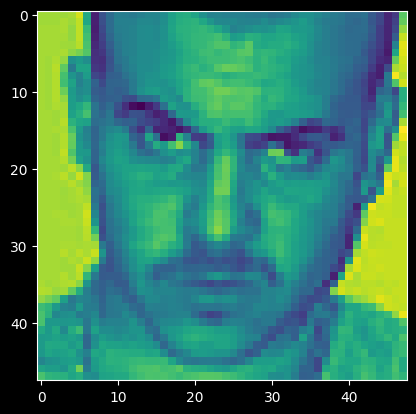

In [12]:
plt.imshow(data[6])

In [13]:
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_ints),
    y=y_ints
)
class_weights = dict(enumerate(weights))
print("Class weights (by index):")
print(class_weights)

Class weights (by index):
{0: np.float64(1.3513271696987772), 1: np.float64(3.8876018876018876), 2: np.float64(1.2642299107142858), 3: np.float64(0.7297471412465776), 4: np.float64(1.0499362762136484), 5: np.float64(1.0381486997365106), 6: np.float64(0.5192825626038623)}


In [14]:
xtrain, xtest, ytrain, ytest = train_test_split(data, result, test_size=0.2, random_state=42,shuffle=True)

In [15]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss=loss_fn,
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_model_v2.h5',  
    monitor='val_loss',         
    save_best_only=True,        
    verbose=1
)


In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 7,                
    restore_best_weights=True,
    verbose=1
)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [19]:
model.fit(
    data, result,
    validation_data=(xtest, ytest), 
    batch_size=64,
    epochs=20,
    callbacks=[checkpoint, early_stop, reduce_lr],
    class_weight=class_weights
)


Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.6123 - loss: 1.3541
Epoch 1: val_loss improved from inf to 1.23457, saving model to best_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 55s 323ms/step - accuracy: 0.6123 - loss: 1.3541 - val_accuracy: 0.6431 - val_loss: 1.2346 - learning_rate: 3.0000e-04
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.6287 - loss: 1.2951
Epoch 2: val_loss did not improve from 1.23457
142/142 ━━━━━━━━━━━━━━━━━━━━ 44s 312ms/step - accuracy: 0.6287 - loss: 1.2952 - val_accuracy: 0.6420 - val_loss: 1.2498 - learning_rate: 3.0000e-04
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.6503 - loss: 1.2756
Epoch 3: val_loss did not improve from 1.23457
142/142 ━━━━━━━━━━━━━━━━━━━━ 45s 317ms/step - accuracy: 0.6503 - loss: 1.2756 - val_accuracy: 0.6376 - val_loss: 1.2371 - learning_rate: 3.0000e-04
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6495 - loss: 1.2628
Epoch 4: val_loss improved from 1.23457 to 1.20437, saving model to best_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 45s 317ms/step - accuracy: 0.6495 - loss: 1.2629 - val_accuracy: 0.6591 - val_loss: 1.2044 - learning_rate: 3.0000e-04
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6563 - loss: 1.2494
Epoch 5: val_loss improved from 1.20437 to 1.12795, saving model to best_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 45s 316ms/step - accuracy: 0.6562 - loss: 1.2494 - val_accuracy: 0.6966 - val_loss: 1.1280 - learning_rate: 3.0000e-04
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.6607 - loss: 1.2293
Epoch 6: val_loss did not improve from 1.12795
142/142 ━━━━━━━━━━━━━━━━━━━━ 44s 312ms/step - accuracy: 0.6607 - loss: 1.2293 - val_accuracy: 0.6343 - val_loss: 1.2495 - learning_rate: 3.0000e-04
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.6623 - loss: 1.2147
Epoch 7: val_loss improved from 1.12795 to 1.09995, saving model to best_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 46s 323ms/step - accuracy: 0.6623 - loss: 1.2148 - val_accuracy: 0.7192 - val_loss: 1.0999 - learning_rate: 3.0000e-04
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6915 - loss: 1.1832
Epoch 8: val_loss did not improve from 1.09995
142/142 ━━━━━━━━━━━━━━━━━━━━ 45s 313ms/step - accuracy: 0.6914 - loss: 1.1833 - val_accuracy: 0.7104 - val_loss: 1.1176 - learning_rate: 3.0000e-04
Epoch 9/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6827 - loss: 1.1841
Epoch 9: val_loss did not improve from 1.09995
142/142 ━━━━━━━━━━━━━━━━━━━━ 54s 379ms/step - accuracy: 0.6827 - loss: 1.1841 - val_accuracy: 0.6977 - val_loss: 1.1026 - learning_rate: 3.0000e-04
Epoch 10/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.6948 - loss: 1.1805
Epoch 10: val_loss did not improve from 1.09995
142/142 ━━━━━━━━━━━━━━━━━━━━ 57s 398ms/step - accuracy: 0.6948 - loss: 1.1805 - val_accuracy: 0.6856 - val_loss: 1.1531 - learning_rate: 3.0000e-04
E

142/142 ━━━━━━━━━━━━━━━━━━━━ 68s 480ms/step - accuracy: 0.6876 - loss: 1.1721 - val_accuracy: 0.7204 - val_loss: 1.0661 - learning_rate: 3.0000e-04
Epoch 12/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7074 - loss: 1.1427
Epoch 12: val_loss did not improve from 1.06611
142/142 ━━━━━━━━━━━━━━━━━━━━ 61s 426ms/step - accuracy: 0.7074 - loss: 1.1428 - val_accuracy: 0.6718 - val_loss: 1.1816 - learning_rate: 3.0000e-04
Epoch 13/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7167 - loss: 1.1306
Epoch 13: val_loss did not improve from 1.06611
142/142 ━━━━━━━━━━━━━━━━━━━━ 51s 361ms/step - accuracy: 0.7167 - loss: 1.1308 - val_accuracy: 0.7165 - val_loss: 1.1138 - learning_rate: 3.0000e-04
Epoch 14/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7172 - loss: 1.1102
Epoch 14: val_loss improved from 1.06611 to 1.04764, saving model to best_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7172 - loss: 1.1103 - val_accuracy: 0.7424 - val_loss: 1.0476 - learning_rate: 3.0000e-04
Epoch 15/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.7195 - loss: 1.1160
Epoch 15: val_loss improved from 1.04764 to 1.04009, saving model to best_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 52s 367ms/step - accuracy: 0.7195 - loss: 1.1160 - val_accuracy: 0.7452 - val_loss: 1.0401 - learning_rate: 3.0000e-04
Epoch 16/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.7320 - loss: 1.1053
Epoch 16: val_loss did not improve from 1.04009
142/142 ━━━━━━━━━━━━━━━━━━━━ 53s 371ms/step - accuracy: 0.7320 - loss: 1.1054 - val_accuracy: 0.7352 - val_loss: 1.0488 - learning_rate: 3.0000e-04
Epoch 17/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.7342 - loss: 1.1033
Epoch 17: val_loss improved from 1.04009 to 1.03568, saving model to best_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 59s 415ms/step - accuracy: 0.7342 - loss: 1.1033 - val_accuracy: 0.7369 - val_loss: 1.0357 - learning_rate: 3.0000e-04
Epoch 18/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.7431 - loss: 1.0796
Epoch 18: val_loss improved from 1.03568 to 0.99285, saving model to best_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 52s 366ms/step - accuracy: 0.7431 - loss: 1.0797 - val_accuracy: 0.7744 - val_loss: 0.9928 - learning_rate: 3.0000e-04
Epoch 19/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.7422 - loss: 1.0762
Epoch 19: val_loss did not improve from 0.99285
142/142 ━━━━━━━━━━━━━━━━━━━━ 52s 363ms/step - accuracy: 0.7422 - loss: 1.0763 - val_accuracy: 0.7380 - val_loss: 1.0675 - learning_rate: 3.0000e-04
Epoch 20/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.7573 - loss: 1.0477
Epoch 20: val_loss improved from 0.99285 to 0.97804, saving model to best_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 46s 327ms/step - accuracy: 0.7572 - loss: 1.0479 - val_accuracy: 0.7750 - val_loss: 0.9780 - learning_rate: 3.0000e-04
Restoring model weights from the end of the best epoch: 20.


In [20]:
test_loss, test_acc = model.evaluate(xtest, ytest)

print('Test Accuracy: ', test_acc)

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7615 - loss: 0.9869
Test Accuracy:  0.774958610534668


In [21]:
model.save('model_v2.h5')

In [1]:
from tensorflow.keras.models import load_model

model = load_model('model_v2.h5')


In [2]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=5e-5),  # ⬅️ lower LR for fine-tuning
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_val, y_train, y_val = train_test_split(
    data, result,
    test_size=0.1,
    random_state=42,
    stratify=np.argmax(result, axis=1)
)


In [10]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weights = dict(enumerate(class_weights))


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('final_model_finetuned.keras', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1)


In [12]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop, reduce_lr],
    shuffle=True
)


Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - accuracy: 0.7635 - loss: 1.0514 - val_accuracy: 0.8401 - val_loss: 0.8784 - learning_rate: 5.0000e-05
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 326ms/step - accuracy: 0.7665 - loss: 1.0193 - val_accuracy: 0.8434 - val_loss: 0.8749 - learning_rate: 5.0000e-05
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 312ms/step - accuracy: 0.7681 - loss: 1.0212 - val_accuracy: 0.8302 - val_loss: 0.8988 - learning_rate: 5.0000e-05
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 317ms/step - accuracy: 0.7649 - loss: 1.0263 - val_accuracy: 0.8379 - val_loss: 0.8742 - learning_rate: 5.0000e-05
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 313ms/step - accuracy: 0.7792 - loss: 1.0173 - val_accuracy: 0.8479 - val_loss: 0.8655 - learning_rate: 5.0000e-05
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 309ms/step - accuracy: 0.7815 - loss: 1.0047 - val_accuracy: 0.8225 - val_loss: 0.9091 - learning_rate: 5.0000e-05
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 39s 30

In [14]:
test_loss, test_acc = model.evaluate(X_val, y_val)

print('Test Accuracy: ', test_acc)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8535 - loss: 0.8399
Test Accuracy:  0.8478500843048096
